In [2]:
import os
from shapely.geometry import Point, Polygon, MultiPolygon
from datetime import datetime
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import sqlite3 as sl
import itertools
import matplotlib.pyplot as plt

import logging
logging.getLogger().setLevel(logging.INFO) # DEBUG, INFO or WARN

from dotenv import load_dotenv
load_dotenv()

DROOT = '../1-data/'
os.makedirs(os.path.join(DROOT, '3-interim', 'populationmasks'), exist_ok=True)

In [3]:
cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.xlsx'), index_col=0)
cities.head(5)

,City,ctr_name,ctr_lat,ctr_lon,cells,Country,ID_HDC_G0
0,Vienna,Rathaus Wien,48.21080,16.35784,4381,AUT,3027
1,Graz,Hauptplatz Graz,47.06955,15.43383,1168,AUT,3000
2,Brussels,Brussels Town hall,50.84642,4.35232,3747,BEL,2135
3,Berlin,Old City Hall,52.51687,13.41160,5187,DEU,2851
4,Hamburg,Rathaus,53.55035,9.99232,4912,DEU,2531


In [1]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import contextily as ctx
import sqlite3 as sl
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely import wkt
from datetime import datetime
import logging
from tqdm import tqdm
import itertools
import numpy as np
import time

class Isochrones:
    """Facilitates interaction with Bing API Key"""
    
    def __init__(self, BING_KEY, sqlite_path = 'cache.db'): 
        self.api_key = api_key
        self.sqlite_path = sqlite_path
        self.response = ""
        
        self.con = sl.connect(sqlite_path)
        with self.con:
            self.con.execute("""
                CREATE TABLE IF NOT EXISTS isochrone (
                    id       INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
                    uid      TEXT NOT NULL UNIQUE,
                    tt_mnts  INTEGER NOT NULL,
                    dep_dt   TIMESTAMP NOT NULL,
                    mode     TEXT NOT NULL,
                    geometry BLOB NOT NULL
                );
            """)
        logging.debug(f'Started new Bing object with key {self.api_key[:10]}...')
        
    def _check_caches(self, ID_HDC_G0, uids):
        """Reads cache with polygons in a SQLite database."""
        
        assert isinstance(uids, pd.DataFrame)
        uids = uids.set_index('uid')
        
        with self.con:
            qry = f"SELECT uid, geometry FROM isochrone WHERE uid LIKE '{ID_HDC_G0}%'; "
            result = uids.merge(pd.read_sql_query(qry, self.con), how='left', on='uid')
            result.geometry = result.geometry.apply(lambda x: wkt.loads(x) if isinstance(x, str) else None)
            result = gpd.GeoDataFrame(result, crs="EPSG:4326")
        return result
            
    def _save_cache(self, uid, tt_mnts, dep_dt, mode, polygon):
        """Saves cache with multipolygon in a SQLite database."""
        try:
            with self.con:
                sql = """
                    INSERT INTO isochrone (uid, tt_mnts, dep_dt, mode, geometry) 
                    values(?, ?, ?, ?, ?)
                """
                result = self.con.execute(sql, (uid, tt_mnts, dep_dt, mode, polygon.iloc[0].wkt))
        except sl.IntegrityError:
            raise sl.IntegrityError(f"Please make sure the UID is unique, '{uid}' is not.")
        
        return result
    
    def snap_coordinates(self, coordinate):
        """
        Some Centroids are not close to a road, and will return a bad result. 
        This function snaps the coordinates to the nearest road.
        """
        url = "https://dev.virtualearth.net/REST/v1/Routes/SnapToRoad"
        params = {
            'points': f"{coordinate.y},{coordinate.x}",
            'travelMode': 'driving',
            'key': self.api_key
        }
        response = requests.get(url, params=params)
        self.response = response
        response_json = response.json()
        
        coords = response_json['resourceSets'][0]['resources']['snappedPoints'][0]['coordinate']
        return Point( (coords['longitude'], coords['latitude']) )
    
    def _get_isochrones_bing(self, to_fetch):
        
        # Fetch in groups, first requesting it and then asking asynchronously for it.
        groupsize = 100
        for x in range(0, len(to_fetch), groupsize):
            
            # Send async start request.
            callbacks = {}
            for i, item in to_fetch.iloc[x:x+groupsize].iterrows():
            
                logging.info(f'Currently requesting {item.uid}')
                #iterator.set_description(f'Requesting {item.uid}')
                
                # Optimise for best result at departure time. This was done wrongly initially, so now fixed.
                optimise = 'time'  # 'timeWithTraffic' if 'driving' in item['mode'] else 'time'

                # Format date string.
                dep_dt_str = item.dep_dt.strftime("%d/%m/%Y %H:%M:%S")

                # Fetch polygon from Bing Maps
                params = {
                    'waypoint': f"{item.startpt.y},{item.startpt.x}", # LatLng
                    'maxTime': item.tt_mnts,
                    'timeUnit': 'minute',
                    'distanceUnit': 'kilometer',
                    'optimise': optimise,
                    'dateTime': dep_dt_str, # Example: 03/01/2011 05:42:00
                    'travelMode': item['mode'],
                    'key': self.api_key
                }
                endpoint = 'https://dev.virtualearth.net/REST/v1/Routes/IsochronesAsync'
                response = requests.get(endpoint, params=params)
                response_json = response.json()
                self.response = response_json
                if len(response_json['resourceSets']) == 1:
                    callbacks[item.uid] = response_json['resourceSets'][0]['resources'][0]['callbackUrl']
                else:
                    callbacks[item.uid] = False
            
            # We assume that sending these requests took longer than 4 seconds..
            for i, item in to_fetch.iloc[x:x+groupsize].iterrows(): 
                
                #iterator.set_description(f'Fetching {item.uid}')
                if not callbacks[item.uid]:
                    continue
                
                logging.info(f'Currently fetching created {item.uid}')
                callback_json = requests.get(callbacks[item.uid]).json()
                callback_result_url = callback_json['resourceSets'][0]['resources'][0]['resultUrl']
                response_json = requests.get(callback_result_url).json()
                
                # Extract polygons to MultiPolygon
                polygons = []
                if ((len(response_json['resourceSets']) == 0) or 
                    ('polygons' not in response_json['resourceSets'][0]['resources'][0])): 
                    logging.warning(f"No resourceSets found for: {item.uid}")
                else:
                    for l1 in response_json['resourceSets'][0]['resources'][0]['polygons']:
                        for l2 in l1['coordinates']:
                            polygons.append(Polygon([[e[1], e[0]] for e in l2]))
                result = gpd.GeoSeries(MultiPolygon(polygons)).set_crs("EPSG:4326")
                
                self._save_cache(item.uid, item.tt_mnts, item.dep_dt.to_pydatetime(), item['mode'], result)

    def get_isochrones_bing(self, city_id, batch, buf_m=0, tqdm=True):
        """
        Gets isochrones from Bing Maps for a specific point. 
        :ID_HDC_G0       City to be searched.
        :batch           Iter with each [(starpt, uid, tt_mnts, (mode, dep_dt))]
        :param buf_m     [Optional] Amount of padding in polygon in meters.
        :param tqdm      [Optional] Show loading indicator of the points.
        
        Param batch is subject to the following:
        :param starpt    A Shapely point which is the origin.
        :param uid       Unique location ID for saving in the caching database.
        :param tt_mnts   Maximum travel time
        :param mode      Travel mode in [driving, walking, transit]
        :param dep_dt    Departure datetime object.
        :return          Reachable areas in row in format MultiPolygon.
        """
            
        # Input checks
        global response
        for (pid, startpt), tt_mnts, (mode, modetime, dep_dt) in batch:
            assert isinstance(startpt, Point)
            assert isinstance(dep_dt, datetime)
            assert isinstance(tt_mnts, int)
            assert tt_mnts >= 5
            assert tt_mnts <= 45
            assert mode in ['driving', 'walking', 'transit']
            assert isinstance(tt_mnts, int)
        assert buf_m >= 0
        
        # Generate combinations with ((pid,point), (mode/modetime/date), minutes, uid).
        batch = [(pid, startpt, tt_mnts, mode, modetime, dep_dt)
                 for (pid, startpt), tt_mnts, (mode, modetime, dep_dt) in list(batch)]
        batch = pd.DataFrame(batch, columns=['pid', 'startpt', 'tt_mnts', 'mode', 'modetime', 'dep_dt'])
        batch['uid'] = batch.apply(lambda x: f"{city_id}-{x.pid}-{x.modetime}-{x.tt_mnts}m-v0", axis=1)
    
        # Check cache
        fetched = self._check_caches(city_id, batch)
        to_fetch = batch[fetched.geometry.isna()]
        logging.info(f"Out of total {len(batch)}, {100-len(to_fetch)/len(batch)*100:.2f}% cached.")
        
        for x in ():
            time.sleep(1)
            print(x)
        
        
        
        # To guarantee safety, we only pull out our queries from the (now filled) database.
        result = self._check_caches(city_id, batch)
        
        # Add padding as per requirement
        if buf_m > 0:
            result = result.to_crs(result.estimate_utm_crs())
            result.geometry = result.geometry.buffer(buf_m)
            result = result.to_crs("EPSG:4326")
        
        return result

In [26]:
BING_KEY = os.environ['BING_API_KEY']
CACHE = os.path.join(DROOT, '3-interim', 'bing_cache.db')
client = Isochrones(bing_key=BING_KEY, CACHE)

            id       INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
            uid      TEXT NOT NULL UNIQUE,
            tt_mnts  INTEGER NOT NULL,
            dep_dt   TIMESTAMP NOT NULL,
            mode     TEXT NOT NULL,
            geometry BLOB NOT NULL

In [4]:
for i, city in cities.iterrows():
    print(city.City)
    file = f'{city.ID_HDC_G0}.pcl'
    df = pd.read_pickle(os.path.join(DROOT, '3-interim', 'populationmasks', file))
    gdf = gpd.GeoDataFrame(df)
    
    origins  = enumerate(gdf.centroid.to_crs("EPSG:4326"))
    times    = [5, 15, 25, 35, 45]
    modes_dt = [
        ('driving', 'driving-free', datetime(2023, 5, 2, 8, 30, 37)), 
#         ('driving', 'driving',      datetime(2023, 5, 2, 13, 0, 37)), 
#       ('transit', 'transit-peak', datetime(2023, 5, 2, 8, 30, 37)),
#       ('transit', 'transit',      datetime(2023, 5, 2, 13, 0, 37)), 
#       ('walking', 'walking',      datetime(2023, 5, 2, 8, 30, 37))
    ]
    
    batch      = list(itertools.product(origins, times, modes_dt))
    isochrones = client.get_isochrones_async(city.ID_HDC_G0, batch)

Vienna


INFO:root:Out of total 3920, 100.00% cached.


Graz


INFO:root:Out of total 730, 100.00% cached.


Brussels


INFO:root:Out of total 2660, 83.27% cached.
INFO:root:Currently fetching 2135-177-transit-peak-5m-v0
INFO:root:Currently fetching 2135-177-transit-peak-15m-v0
INFO:root:Currently fetching 2135-177-transit-peak-25m-v0
INFO:root:Currently fetching 2135-177-transit-peak-35m-v0
INFO:root:Currently fetching 2135-177-transit-peak-45m-v0
INFO:root:Currently fetching 2135-178-transit-peak-5m-v0
INFO:root:Currently fetching 2135-178-transit-peak-15m-v0
INFO:root:Currently fetching 2135-178-transit-peak-25m-v0
INFO:root:Currently fetching 2135-178-transit-peak-35m-v0
INFO:root:Currently fetching 2135-178-transit-peak-45m-v0
INFO:root:Currently fetching 2135-179-transit-peak-5m-v0
INFO:root:Currently fetching 2135-179-transit-peak-15m-v0
INFO:root:Currently fetching 2135-179-transit-peak-25m-v0
INFO:root:Currently fetching 2135-179-transit-peak-35m-v0
INFO:root:Currently fetching 2135-179-transit-peak-45m-v0
INFO:root:Currently fetching 2135-180-transit-peak-5m-v0
INFO:root:Currently fetching 213

INFO:root:Currently fetching 2135-197-transit-peak-5m-v0
INFO:root:Currently fetching 2135-197-transit-peak-15m-v0
INFO:root:Currently fetching 2135-197-transit-peak-25m-v0
INFO:root:Currently fetching 2135-197-transit-peak-35m-v0
INFO:root:Currently fetching 2135-197-transit-peak-45m-v0
INFO:root:Currently fetching 2135-198-transit-peak-5m-v0
INFO:root:Currently fetching 2135-198-transit-peak-15m-v0
INFO:root:Currently fetching 2135-198-transit-peak-25m-v0
INFO:root:Currently fetching 2135-198-transit-peak-35m-v0
INFO:root:Currently fetching 2135-198-transit-peak-45m-v0
INFO:root:Currently fetching 2135-199-transit-peak-5m-v0
INFO:root:Currently fetching 2135-199-transit-peak-15m-v0
INFO:root:Currently fetching 2135-199-transit-peak-25m-v0
INFO:root:Currently fetching 2135-199-transit-peak-35m-v0
INFO:root:Currently fetching 2135-199-transit-peak-45m-v0
INFO:root:Currently fetching 2135-200-transit-peak-5m-v0
INFO:root:Currently fetching 2135-200-transit-peak-15m-v0
INFO:root:Currentl

INFO:root:Currently fetching 2135-210-transit-peak-5m-v0
INFO:root:Currently fetching 2135-210-transit-peak-15m-v0
INFO:root:Currently fetching 2135-210-transit-peak-25m-v0
INFO:root:Currently fetching 2135-210-transit-peak-35m-v0
INFO:root:Currently fetching 2135-210-transit-peak-45m-v0
INFO:root:Currently fetching 2135-211-transit-peak-5m-v0
INFO:root:Currently fetching 2135-211-transit-peak-15m-v0
INFO:root:Currently fetching 2135-211-transit-peak-25m-v0
INFO:root:Currently fetching 2135-211-transit-peak-35m-v0
INFO:root:Currently fetching 2135-211-transit-peak-45m-v0
INFO:root:Currently fetching 2135-212-transit-peak-5m-v0
INFO:root:Currently fetching 2135-212-transit-peak-15m-v0
INFO:root:Currently fetching 2135-212-transit-peak-25m-v0
INFO:root:Currently fetching 2135-212-transit-peak-35m-v0
INFO:root:Currently fetching 2135-212-transit-peak-45m-v0
INFO:root:Currently fetching 2135-213-transit-peak-5m-v0
INFO:root:Currently fetching 2135-213-transit-peak-15m-v0
INFO:root:Currentl

INFO:root:Currently fetching 2135-217-transit-peak-5m-v0
INFO:root:Currently fetching 2135-217-transit-peak-15m-v0
INFO:root:Currently fetching 2135-217-transit-peak-25m-v0
INFO:root:Currently fetching 2135-217-transit-peak-35m-v0
INFO:root:Currently fetching 2135-217-transit-peak-45m-v0
INFO:root:Currently fetching 2135-218-transit-peak-5m-v0
INFO:root:Currently fetching 2135-218-transit-peak-15m-v0
INFO:root:Currently fetching 2135-218-transit-peak-25m-v0
INFO:root:Currently fetching 2135-218-transit-peak-35m-v0
INFO:root:Currently fetching 2135-218-transit-peak-45m-v0
INFO:root:Currently fetching 2135-219-transit-peak-5m-v0
INFO:root:Currently fetching 2135-219-transit-peak-15m-v0
INFO:root:Currently fetching 2135-219-transit-peak-25m-v0
INFO:root:Currently fetching 2135-219-transit-peak-35m-v0
INFO:root:Currently fetching 2135-219-transit-peak-45m-v0


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
for x in (iterator := tqdm(range(0, 10, 2), leave=False) ):
    time.sleep(1)

In [ ]:
ax = gdf.plot()
gdf.iloc[40:50].plot(edgecolor=u'white', color=np.random.rand(3,), ax=ax)

In [17]:
coords = some_data['resourceSets'][0]['resources'][0]['polygons']

In [18]:
polygons = []
for l1 in coords:
    for l2 in l1['coordinates']:
        polygons.append(Polygon([[e[1], e[0]] for e in l2]))
result = gpd.GeoSeries(MultiPolygon(polygons)).set_crs("EPSG:4326")

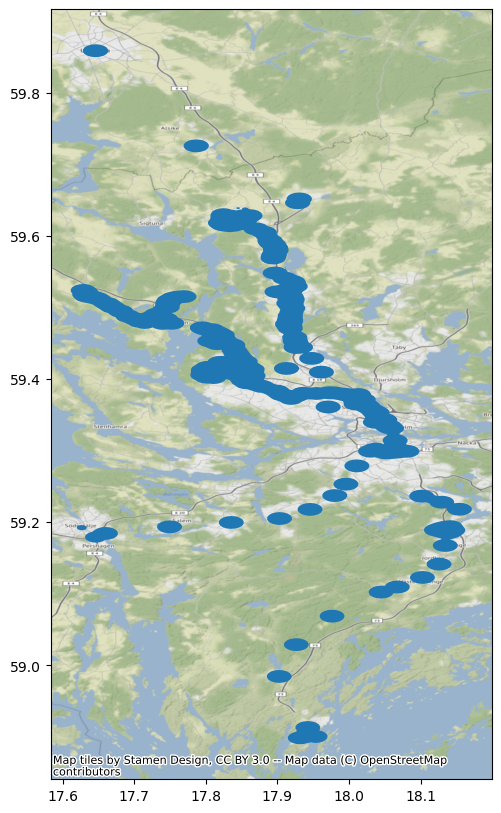

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
result.plot(ax=ax)
ctx.add_basemap(ax, crs=result.crs)